In [1]:
# imports
from sqlalchemy import create_engine, Column, String, Integer, Float, Date, MetaData, Table, type_coerce
from sqlalchemy.orm import mapper, create_session
import csv
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
import numbers
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import datetime as dt
import os
import re
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import pandas as pd
%matplotlib inline

In [2]:
# First, calculate river concentrations from EC data at Hope and Gravesend
# NOTE: am assuming all forms of N are reported in grams of N, so that mole conversion is 
#  by division by 14.006720 (mol. weight N), rather than weights of full molecules. This 
#  is consistent with NO23 values in Susan's notebook.
#  This is consistent with report in 'precdetectlimits.pdf', although it is rather old.
#  However, assume Si in grams of SiO2 (mo. weight = 60.08). This is consistent with 
#  Si data in Susan's notebook (http://nbviewer.jupyter.org/url/bitbucket.org/salishsea/tools/
#     raw/tip/I_ForcingFiles/Rivers/FraserRiverNutrients.ipynb?at=default&fileviewer=file-
#     view-default)
# Also appears to result in rough consistency with Debby's river Si and NO3 values
mwN=14.006720
#mwSiO3=76.083820
mwSiO2=60.08
mwAmm=17.031 ## ammonia NH3 g/mol
#
#  nh4 muM  (N) = nh4_cst from mean of data at Hope/Gravesend
#  don muM  (N) = don_cst from mean of data at Hope/Gravesend
#     - only 1 data point available. Should use it or set to zero? Sutton (2013) suggests DON may be unreactive on timescales
#       of exchange of water in SoG, but Clair (2013) reports that organic nitrogen dominated total nitrogen in 
#       Canadian rivers.
#       -> for now, using available data point
#  no3 muM  (N) -> daily from smoothed data
#  sil muM (Si) -> daily from smoothed data
#  dia muM  (N) = 0.001
dia = 0.001
#  phy muM  (N) = 0.001
phy = 0.001
#  mes muM  (N) = 0.001
mes = 0.001
#  zoo muM  (N) = 0.001
zoo = 0.001
#  pon muM  (N) = 0.0
pon = 0.0
#  bsi muM (Si) = 0.0
don=0.0
bsi = 0.0
#  oxy ? empty
oxy = 160
# other rivers const vals:
const_si=59.57 ## updated June 2019
const_no=6.18 ## updated June 2019
const_nh=4.30 ## updated June 2019
const_tur=1.0 # default river turbidity (NTU)

In [3]:
# load EC Rivers database
dbpath='/ocean/eolson/MEOPAR/obs/ECRivers/ECRiversDB'
engine = create_engine('sqlite:///'+dbpath+'.sqlite')
Base = automap_base()
Base.prepare(engine, reflect=True)
Profs=Base.classes.profiles
session = create_session(bind = engine, autocommit = False, autoflush = True)
# relevant data types: 
#('NITROGEN DISSOLVED NITRATE',)
#('NITROGEN DISSOLVED NO3 & NO2',)
#('NITROGEN DISSOLVED ORGANIC (CALCD.)',)
#('NITROGEN NITRITE',)
#('NITROGEN TOTAL',)
#('NITROGEN TOTAL DISSOLVED',)
#('NITROGEN TOTAL ORGANIC (CALCD.)',)
#('SALINITY',)
#('SILICA DISSOLVED',)
#('SILICA EXTRACTABLE',)
#('SILICA REACTIVE',)
#('SILICON DISSOLVED',)
#('SILICON EXTRACTABLE',)
#('SILICON TOTAL',)
#('TURBIDITY',)


In [4]:
#define function to plot results of query as repeating fxn of year-day if output rows contain Year, Month, Day, value:
def plotYMDV(qout,pcolor,ptitle):
    Y=[]
    M=[]
    D=[]
    Amm=[]
    date=[]
    for Y0, M0, D0, Amm0 in qout:
        Y.append(Y0)
        M.append(M0)
        D.append(D0)
        Amm.append(Amm0)
        date.append(dt.date(Y0,M0,D0))
    Y=np.array(Y)
    M=np.array(M)
    D=np.array(D)
    Amm=np.array(Amm)
    date=np.array(date)
    YD=0.0*Y
    for i in range(0,len(Y)):
        YD[i]=date[i].timetuple().tm_yday
    plt.plot(YD,Amm,'.',color=pcolor)
    plt.plot(YD+365.0,Amm,'.',color=pcolor)
    plt.title(ptitle)
    plt.plot((366,366),(0,np.max(Amm)),'k--')
    return(YD,Amm)
    
# definte function to smooth data with gaussian filter, plot result, and return dict of days, values
def gsmooth(YD,Amm,L):
    allt=np.arange(1,367)
    fil=np.empty(np.size(allt))
    s=L/2.355
    sdict={}
    for t in allt:
        diff=[min(abs(x-t),abs(x-t+365), abs(x-t-365)) for x in YD]
        weight=[np.exp(-.5*x**2/s**2) if x <= 3*L else 0.0 for x in diff]
        #weight=[np.exp(-.5*x**2/s**2) for x in diff]
        fil[t-1]=np.sum(weight*Amm)/np.sum(weight)
        sdict[t]=fil[t-1]
    plt.plot(allt,fil,'k-')
    plt.plot(allt+365,fil,'k-')
    diff_ex=[min(abs(x-t),abs(x-t+365), abs(x-t-365)) for x in allt]
    weight_ex=[np.exp(-.5*x**2/s**2) if x <= 3*L else 0.0 for x in diff_ex]
    plt.plot(allt,weight_ex/np.sum(weight_ex)*np.max(2.0*Amm),'k:')
    plt.plot(allt+365,weight_ex/np.sum(weight_ex)*np.max(2.0*Amm),'k:')
    return(sdict)
    #plt.plot(YD,weight,'*')

units: ('MG/L',)
don_cst = 17.1346325192 uM N ....DON"T USE


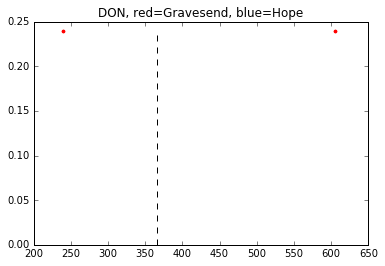

In [5]:
# calculate mean DON from data at Hope and Gravesend:

qdataG=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.variable_name=='NITROGEN DISSOLVED ORGANIC (CALCD.)',
                Profs.station_name=='Fraser River (Main Arm) at Gravesend Reach - Buoy'))
if qdataG.count()>0:
    YDG, valG = plotYMDV(qdataG.all(),'r','DON, red=Gravesend, blue=Hope')
    
qdataH=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.variable_name=='NITROGEN DISSOLVED ORGANIC (CALCD.)',
                Profs.station_name.like('%Hope%')))
if qdataH.count()>0:
    YDH, valH = plotYMDV(qdataH.all(),'b',)
else:
    YDH=[]
    valH=[]

units=session.query(Profs.unit_code).\
            filter(and_(
                Profs.variable_name=='NITROGEN DISSOLVED ORGANIC (CALCD.)',
                or_(Profs.station_name=='Fraser River (Main Arm) at Gravesend Reach - Buoy',
                    Profs.station_name.like('%Hope%')))).group_by(Profs.unit_code).all()
for row in units:
    print('units:',row)
val=np.concatenate((valG,valH))
don_cst=np.mean(val)
print('don_cst =', don_cst/mwN*1000, 'uM N ....DON"T USE')

In [6]:
def returnDF(fname):
    obsdir='/ocean/eolson/MEOPAR/obs/ECRivers/SOGRivers'
    df=pd.read_csv(os.path.join(obsdir,fname))
    temp=[dt.datetime.strptime(s, "%Y-%m-%d %H:%M:%S") for s in df['Sample time']]
    df['TS']=temp
    df['YD']=[(t-dt.datetime(t.year-1,12,31)).days for t in temp]
    return df
df0=dict()
df0['Fraser-Hope']=returnDF('BC08MF0001_FraserHope_19790717_to_20170125.csv')
df0['Fraser-Gravesend']=returnDF('BC08MH0453_FraserGravesend_20080902_to_20161104.csv')

[('Fraser-Gravesend', 'Ammonia Dissolved [Lab: -54] [VMV: 1109]'), ('Fraser-Hope', 'Ammonia Dissolved [Lab: 1] [VMV: 7557]')]
nh4_cst = 4.23255330777 uM


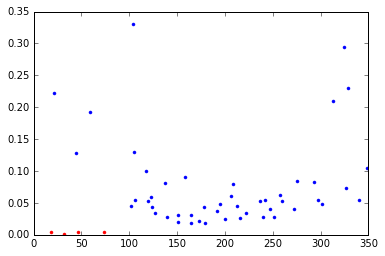

In [7]:
# calculate mean NH4 from data at Hope and Gravesend

llNH=list()
for ff in df0.keys():
    llNH=llNH+[(ff,i) for i in df0[ff].keys() if ((re.search('[Aa]mm',i) is not None) \
                                                  and (re.search('[Dd]is',i) is not None))]
print(llNH)
plt.plot(df0['Fraser-Hope']['YD'],
         df0['Fraser-Hope']['Ammonia Dissolved [Lab: 1] [VMV: 7557]'],'r.')
plt.plot(df0['Fraser-Gravesend']['YD'],
         df0['Fraser-Gravesend']['Ammonia Dissolved [Lab: -54] [VMV: 1109]'],'b.')
val=np.concatenate((df0['Fraser-Hope']['Ammonia Dissolved [Lab: 1] [VMV: 7557]'],
                    df0['Fraser-Gravesend']['Ammonia Dissolved [Lab: -54] [VMV: 1109]']))

nh4_cst=np.nanmean(val)
print('nh4_cst =', nh4_cst/mwAmm*1000, 'uM')

NO3
Fraser-Gravesend Nitrogen Dissolved Nitrate [Lab: -54] [VMV: 1115] 2009-05-13 20:20:00 2015-04-30 20:45:00
Fraser-Hope Nitrogen Dissolved Nitrate [Lab: 1] [VMV: 7315] 1994-04-26 17:00:00 1994-09-27 21:15:00
Fraser-Hope Nitrogen Dissolved Nitrate [Lab: 36] [VMV: 7315] 1994-10-11 21:35:00 1998-12-08 22:10:00
Fraser-Hope Nitrogen Dissolved Nitrate [Lab: -54] [VMV: 1115] 2006-09-26 21:45:00 2015-05-25 18:11:00


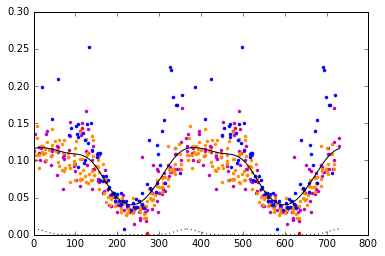

In [8]:
# NO2+NO3 at Hope and Gravesend
llNO3=list()
for ff in df0.keys():
    llNO3=llNO3+[(ff,i) for i in df0[ff].keys() if ((re.search('[Nn]itrate',i) is not None and re.search('[Nn]itrite',i) is None and re.search('[Dd]is',i) is not None))]
print('NO3')
for (ff,i) in llNO3:
    print(ff,i,np.min(df0[ff]['TS'][df0[ff][i]>=0]),np.max(df0[ff]['TS'][df0[ff][i]>=0]))

plt.plot(df0['Fraser-Hope']['YD'],
         df0['Fraser-Hope']['Nitrogen Dissolved Nitrate [Lab: 1] [VMV: 7315]'],'r.')
plt.plot(df0['Fraser-Hope']['YD'],
         df0['Fraser-Hope']['Nitrogen Dissolved Nitrate [Lab: 36] [VMV: 7315]'],'m.')
plt.plot(df0['Fraser-Hope']['YD'],
         df0['Fraser-Hope']['Nitrogen Dissolved Nitrate [Lab: -54] [VMV: 1115]'],'.',color='darkorange')
plt.plot(df0['Fraser-Gravesend']['YD'],
         df0['Fraser-Gravesend']['Nitrogen Dissolved Nitrate [Lab: -54] [VMV: 1115]'],'b.')
plt.plot(df0['Fraser-Hope']['YD']+365,
         df0['Fraser-Hope']['Nitrogen Dissolved Nitrate [Lab: 1] [VMV: 7315]'],'r.')
plt.plot(df0['Fraser-Hope']['YD']+365,
         df0['Fraser-Hope']['Nitrogen Dissolved Nitrate [Lab: 36] [VMV: 7315]'],'m.')
plt.plot(df0['Fraser-Hope']['YD']+365,
         df0['Fraser-Hope']['Nitrogen Dissolved Nitrate [Lab: -54] [VMV: 1115]'],'.',color='darkorange')
plt.plot(df0['Fraser-Gravesend']['YD']+365,
         df0['Fraser-Gravesend']['Nitrogen Dissolved Nitrate [Lab: -54] [VMV: 1115]'],'b.')
val=np.concatenate((df0['Fraser-Hope']['Nitrogen Dissolved Nitrate [Lab: 1] [VMV: 7315]'],
                    df0['Fraser-Hope']['Nitrogen Dissolved Nitrate [Lab: 36] [VMV: 7315]'],
                    df0['Fraser-Hope']['Nitrogen Dissolved Nitrate [Lab: -54] [VMV: 1115]'],
                    df0['Fraser-Gravesend']['Nitrogen Dissolved Nitrate [Lab: -54] [VMV: 1115]']))
YD=np.concatenate((df0['Fraser-Hope']['YD'],
                    df0['Fraser-Hope']['YD'],
                    df0['Fraser-Hope']['YD'],
                    df0['Fraser-Gravesend']['YD']))
ii=~np.isnan(val)
no3dict=gsmooth(YD[ii],val[ii],60)
#print(i,np.max([v for v in no3dict.values()]))

Si
Fraser-Hope Silica Dissolved [Lab: 36] [VMV: 103469] 1991-03-08 18:10:00 1999-12-21 22:10:00


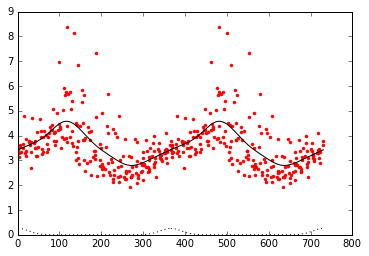

In [9]:
# Si at Hope and Gravesend
ll=list()
for ff in df0.keys():
    ll=ll+[(ff,i) for i in df0[ff].keys() if ((re.search('[Ss]ilica',i) is not None) and (re.search('[Dd]is',i) is not None)) ]
print('Si')
for (ff,i) in ll:
    print(ff,i,np.min(df0[ff]['TS'][df0[ff][i]>=0]),np.max(df0[ff]['TS'][df0[ff][i]>=0]))
    
plt.plot(df0['Fraser-Hope']['YD'],
         df0['Fraser-Hope']['Silica Dissolved [Lab: 36] [VMV: 103469]'],'r.')
plt.plot(df0['Fraser-Hope']['YD']+365,
         df0['Fraser-Hope']['Silica Dissolved [Lab: 36] [VMV: 103469]'],'r.')
  
YD=df0['Fraser-Hope']['YD']
val=df0['Fraser-Hope']['Silica Dissolved [Lab: 36] [VMV: 103469]']
ii=~np.isnan(val)
sidict=gsmooth(YD[ii],val[ii],60)

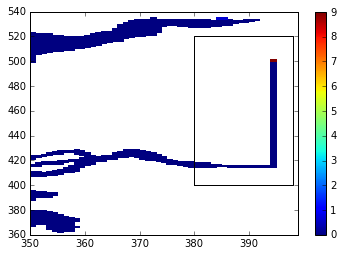

In [10]:
# find fraser location
mesh=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
tmask=mesh.variables['tmask'][0,0,:,:]
f=nc.Dataset('/results/forcing/rivers/R201702DFraCElse_y2016m01d23.nc') # example for dims
plt.pcolormesh(np.ma.masked_where(tmask==0,f.variables['rorunoff'][0,:,:]))
plt.colorbar()
plt.xlim(350,399)
plt.ylim(360,540)
plt.plot((380,398,398,380,380),(400,400,520,520,400),'k-')

In [11]:
f.variables['time_counter'][:]

masked_array(data = [--],
             mask = [ True],
       fill_value = 9.96921e+36)

In [12]:
# create daily files, use data to initialize fields
year=2016
fname='/data/eolson/MEOPAR/NEMO-forcing-new/rivers-climatology/bio/R201906_bioClim_'
for yearday in range(1,367):
    t2=dt.date(year, 1, 1) + dt.timedelta(days = yearday - 1)
    #datestr='y'+t2.strftime('%Y')+'m'+t2.strftime('%m')+'d'+t2.strftime('%d')
    datestr='m'+t2.strftime('%m')+'d'+t2.strftime('%d')
    new=nc.Dataset(fname+datestr+'.nc','w')
    #Copy dimensions
    for dname, the_dim in f.dimensions.items():
        #print (dname, len(the_dim) if not the_dim.isunlimited() else None)
        new.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
    #new_tc=new.createVariable('time_counter',float,('time_counter'),zlib=True)
    #new_tc[:]=f.variables['time_counter'][:]
    
    new_run=new.createVariable('no3',float,('time_counter', 'y', 'x'),zlib=True)
    new_run[:,:,:]=const_no # other river value
    new_run[:,400:520,380:]=no3dict[yearday]/mwN*1000.0 # convert to muM; Fraser value

    new_run=new.createVariable('sil',float,('time_counter', 'y', 'x'),zlib=True)
    new_run[:,:,:]=const_si # other river value
    new_run[:,400:520,380:]=sidict[yearday]/mwSiO2*1000.0 # convert to muM; Fraser value
    
    new.close()

In [13]:
# create constants file
f=nc.Dataset('/results/forcing/rivers/R201702DFraCElse_y2016m01d23.nc') # example for dims
year=2016
fnameC='/data/eolson/MEOPAR/NEMO-forcing-new/rivers-climatology/bio/R201906_bioConst'
new=nc.Dataset(fnameC+'.nc','w')
#Copy dimensions
for dname, the_dim in f.dimensions.items():
    #print (dname, len(the_dim) if not the_dim.isunlimited() else None)
    new.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)

#new_tc=new.createVariable('time_counter',float,('time_counter'),zlib=True)
#new_tc[:]=f.variables['time_counter'][:]

new_run=new.createVariable('no3',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:,:,:]=const_no # other rivers
new_run[:,400:520,380:]=np.mean([no3dict[yearday]/mwN*1000.0 for yearday in range(1,367)])

new_run=new.createVariable('nh4',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:,:,:]=const_nh # other river value
new_run[:,400:520,380:]=nh4_cst/mwAmm*1000.0 # convert to muM; Fraser value

new_run=new.createVariable('sil',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=const_si # other river value
new_run[:,400:520,380:]=np.mean([sidict[yearday]/mwSiO2*1000.0 for yearday in range(1,367)])

new_run=new.createVariable('dia',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=dia

new_run=new.createVariable('phy',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=phy

new_run=new.createVariable('mes',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=mes

new_run=new.createVariable('zoo',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=zoo

new_run=new.createVariable('don',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=don

new_run=new.createVariable('pon',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=pon

new_run=new.createVariable('bsi',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=bsi

new_run=new.createVariable('tur',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=const_tur

new.close()

In [14]:
session.close()
engine.dispose()

In [15]:
f.close()
mesh.close()

In [16]:
year=2016
for yearday in range(1,367):
    t2=dt.date(year, 1, 1) + dt.timedelta(days = yearday - 1)
    #datestr='y'+t2.strftime('%Y')+'m'+t2.strftime('%m')+'d'+t2.strftime('%d')
    datestr='m'+t2.strftime('%m')+'d'+t2.strftime('%d')
    new=nc.Dataset(fname+datestr+'.nc')
    print(yearday,[(ikey, np.min(new.variables[ikey]), np.max(new.variables[ikey])) for ikey in new.variables.keys()])
    new.close()

1 [('no3', 6.1799999999999997, 8.2761044385521991), ('sil', 57.08212707723338, 59.57)]
2 [('no3', 6.1799999999999997, 8.2882785962522743), ('sil', 57.206163580199082, 59.57)]
3 [('no3', 6.1799999999999997, 8.2994811508050681), ('sil', 57.329740172292432, 59.57)]
4 [('no3', 6.1799999999999997, 8.3097422957544573), ('sil', 57.452843088808478, 59.57)]
5 [('no3', 6.1799999999999997, 8.3190924830764814), ('sil', 57.575459917952642, 59.57)]
6 [('no3', 6.1799999999999997, 8.3275622467559174), ('sil', 57.697579976153257, 59.57)]
7 [('no3', 6.1799999999999997, 8.335182031345342), ('sil', 57.819194697302521, 59.57)]
8 [('no3', 6.1799999999999997, 8.3419820273049403), ('sil', 57.940298032288815, 59.57)]
9 [('no3', 6.1799999999999997, 8.347992014782081), ('sil', 58.06088685553464, 59.57)]
10 [('no3', 6.1799999999999997, 8.3532412174565813), ('sil', 58.180961373846529, 59.57)]
11 [('no3', 6.1799999999999997, 8.3577581677750405), ('sil', 58.300525533589997, 59.57)]
12 [('no3', 6.1799999999999997, 8.

In [17]:
new=nc.Dataset(fnameC+'.nc')
print(yearday,[(ikey, np.min(new.variables[ikey]), np.max(new.variables[ikey])) for ikey in new.variables.keys()])
new.close()

366 [('no3', 6.1235179805710107, 6.1799999999999997), ('nh4', 4.2325533077690913, 4.2999999999999998), ('sil', 59.554968806333505, 59.57), ('dia', 0.001, 0.001), ('phy', 0.001, 0.001), ('mes', 0.001, 0.001), ('zoo', 0.001, 0.001), ('don', 0.0, 0.0), ('pon', 0.0, 0.0), ('bsi', 0.0, 0.0), ('tur', 1.0, 1.0)]
